# Projet Python - Analyse d'un actif financier à l'aide de simulations de Monte-Carlo

## Introduction
Ce projet a pour objectif de mettre en pratique l’analyse financière et la modélisation stochastique en Python.  
Nous allons :  
- Télécharger et visualiser les données d’un actif financier  
- Calculer ses log-returns  
- Estimer ses paramètres statistiques $(\mu, \sigma)$  
- Simuler des trajectoires de Monte Carlo en supposant un mouvement brownien géométrique (GBM) 
- Implémenter une approche orientée objet avec une classe `Stock` regroupant ces fonctionnalités

## Librairies utilisées

Dans ce projet, nous utilisons plusieurs librairies Python :

- **yfinance** : permet de télécharger facilement les données financières (prix, volumes, etc.) depuis Yahoo Finance.  
  → Ici, nous l’utilisons pour récupérer les prix historiques d’un actif donné (par exemple : Apple, ticker AAPL).

- **matplotlib** : librairie de visualisation.  
  → Afin de tracer les graphiques des prix, des log-returns et des simulations.

- **numpy** : librairie pour le calcul scientifique.  
  → Simplification des différentes formules statistiques (moyenne, écart-type, logarithmes, etc.).

- **pandas** *(optionnelle mais sous-jacente)* : yfinance retourne les données sous forme de `DataFrame` pandas.  
  → Manipulation des séries temporelles de prix.


In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Classe `Stock`

La classe `Stock` regroupe toutes les fonctionnalités liées à un actif financier.  

Elle permet de :  
- Télécharger les données de marché via `yfinance`  
- Calculer les log-returns  
- Estimer les paramètres statistiques $(\mu, \sigma)$ à partir des log-returns  
- Visualiser les prix et les rendements  

### Attributs principaux :
- `ticker` : le symbole de l’actif (ex. `"AAPL"`)  
- `period` : la période d’historique considérée (ex. `"1y"`)  
- `data` : les données de marché téléchargées (DataFrame pandas)  
- `_logret` : les log-returns calculés  
- `_mu_sigma` : le couple $(\mu, \sigma)$ estimé  

### Méthodes principales :
- `data_actif()` : télécharge et stocke les données de l’actif  
- `log_returns()` : calcule les log-returns de l’actif  
- `estimateur_mu_sigma()` : calcule et retourne les estimateurs $(\mu, \sigma)$  
- `plot_history()` et `plot_log_returns()` : affichent les graphiques associés  

Cette approche permet de centraliser toute l’analyse d’un actif dans une seule classe claire et réutilisable.


In [18]:
class Stock:
    def __init__(self, ticker: str, period: str = "1y"):
        self.ticker = ticker
        self.period = period
        self.data: pd.DataFrame | None = None
        self.logret: pd.Series | None = None
        self._mu_sigma: tuple[float, float] | None = None
    
    def data_actif(self) :    
        data = yf.Ticker(self.ticker).history(period=self.period) 
        if data.empty:
            print(f"Aucune donnée trouvée pour {self.ticker} sur {self.periode}.")
            return None
        self.data = data
        return self.data

    def log_returns(self) :
        if self.data is None: # Si les données n'ont pas été chargées, on les charge
            self.data_actif()

        if self.data is None: # Si les données sont toujours vides, on ne peut pas calculer les log-returns
            return None
        
        liste_log_returns = []
        for i in range(1, len(self.data["Close"])) : 
            liste_log_returns.append(np.log(self.data["Close"][i] / self.data["Close"][i-1]))

        self.logret = liste_log_returns
        return self.logret
    
    def plot_history(self) : # Afficher le graphique de l'historique des prix
        if self.data is None:
            raise RuntimeError("Télécharge d'abord les données avec .data_actifs().")
        plt.figure(figsize=(10,5))
        plt.plot(self.data.index, self.data["Close"], label=f"{self.ticker} - Clôture")
        plt.xlabel("Date"); plt.ylabel("Prix"); plt.title(f"Historique {self.ticker} ({self.period})")
        plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()
    
    def plot_log_returns(self) : # Afficher le graphique des log-returns
        if self.logret is None:
            raise RuntimeError("Télécharge d'abord les données avec .log_returns().")
        plt.figure(figsize=(10,5))
        plt.plot(self.data.index[1:], self.logret, label=f"{self.ticker} - log returns")
        plt.xlabel("Date"); plt.ylabel("Prix"); plt.title(f"Log returns {self.ticker} ({self.period})")
        plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

    def estimateur_mu_sigma(self) : # Estimation de mu et sigma d'après les log-returns
        if self.logret is None:
            self.log_returns()
        if self.logret is None:
            return None
        
        sigma = np.std(self.logret) * np.sqrt(252)
        mu = np.mean(self.logret) * 252 + 0.5 * sigma**2

        self.mu_sigma = (mu, sigma)
        return self.mu_sigma

## Pourquoi ne pas choisir $\mu$ et $\sigma$ au hasard ?

Dans la modélisation par mouvement brownien géométrique (GBM), les paramètres $\mu$ (drift) et $\sigma$ (volatilité) jouent un rôle central :  
- $\mu$ décrit la tendance moyenne des rendements de l’actif  
- $\sigma$ décrit l’ampleur des fluctuations autour de cette tendance  

### Limites d’un choix arbitraire
- Choisir $\mu$ et $\sigma$ au hasard reviendrait à ignorer l’information contenue dans les données de marché.  
- Cela rendrait les simulations peu réalistes** et non interprétables : les trajectoires ne refléteraient plus le comportement historique de l’actif.  
- En pratique, cela reviendrait à simuler « n’importe quel actif » plutôt que l’actif étudié.

### Intérêt de l’estimation empirique
Dans ce projet, $\mu$ et $\sigma$ sont estimés à partir des données historiques :  
- $\mu$ est calculé comme la moyenne annualisée des log-returns  
- $\sigma$ est estimé par l’écart-type annualisé des log-returns  

Cette approche garantit que les trajectoires simulées sont calibrées sur les données réelles et donc plus pertinentes pour :  
- illustrer le comportement probable de l’actif,  
- réaliser des analyses de risque,  
- ou comparer plusieurs actifs entre eux.  

En résumé : l’utilisation de paramètres estimés rend les simulations de Monte Carlo plus crédibles et utiles dans un contexte financier.


## Classe `GBMSimulator`

La classe `GBMSimulator` permet de simuler des trajectoires de Monte Carlo sous l’hypothèse d’un mouvement brownien géométrique (GBM).

### Rappel théorique :
Le GBM est défini par l’équation différentielle stochastique :  

$$ dS_t = \mu S_t dt + \sigma S_t dW_t $$

Sa solution analytique est :  

$$ S_t = S_0 \exp \Big( (\mu - \tfrac{1}{2}\sigma^2)t + \sigma W_t \Big) $$

### Attributs principaux :
- `S0` : prix initial  
- `mu` : drift (espérance des log-returns annualisés)  
- `sigma` : volatilité annualisée  
- `T` : horizon de temps (en années)  
- `steps` : nombre de pas de temps dans la simulation   

### Méthode principale :
- `simulate_gbm()` : génère et retourne un tableau des trajectoires simulées  
- `plot_trajectories()` : affiche quelques trajectoires représentatives  

Cette classe permet de visualiser la dynamique possible d’un actif sous l’hypothèse du GBM et d’illustrer les risques liés à la volatilité.

In [15]:
class GBMsimulator : 
    def __init__(self, S0: float, mu: float, sigma: float, T: float = 1.0, steps: int = 252):
        self.S0 = S0
        self.mu = mu
        self.sigma = sigma
        self.T = T
        self.steps = steps

    def simulate_gbm(self, n_paths: int):
        dt = self.T / self.steps
        paths = np.zeros((n_paths, self.steps + 1))
        paths[:, 0] = self.S0

        for i in range(1, self.steps + 1):
            Z = np.random.normal(size=n_paths)
            paths[:, i] = paths[:, i - 1] * np.exp(
                (self.mu - 0.5 * self.sigma ** 2) * dt + self.sigma * np.sqrt(dt) * Z
            )

        return paths
    
    def plot_trajectories(self, paths):
        if paths is None or paths.shape[0] == 0:
            print("Aucune trajectoire à afficher.")
            return
        x_axis = range(self.steps + 1)
        for i in range(paths.shape[0]):
            plt.plot(x_axis, paths[i])
        plt.xlabel("Pas de temps")
        plt.ylabel("Prix simulé")
        plt.title("Trajectoires simulées (GBM)")
        plt.show()

## Exemple d’utilisation des classes `Stock` et `GBMsimulator`

Dans cette section, nous allons illustrer concrètement l’utilisation des classes développées précédemment.  
Nous allons :
- Télécharger les données historiques d’un actif financier,
- Estimer ses paramètres statistiques,
- Simuler plusieurs trajectoires de Monte Carlo à l’aide du modèle GBM,
- Et enfin, afficher sur un même graphique l’évolution réelle du prix et les trajectoires simulées.

Cet exemple permet de visualiser l’intérêt de la modélisation stochastique pour l’analyse du comportement d’un

C:\Users\hermo\AppData\Local\Temp\ipykernel_32548\3998712894.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  liste_log_returns.append(np.log(self.data["Close"][i] / self.data["Close"][i-1]))


Text(0.5, 1.0, 'Historique AAPL et trajectoires Monte Carlo (GBM)')

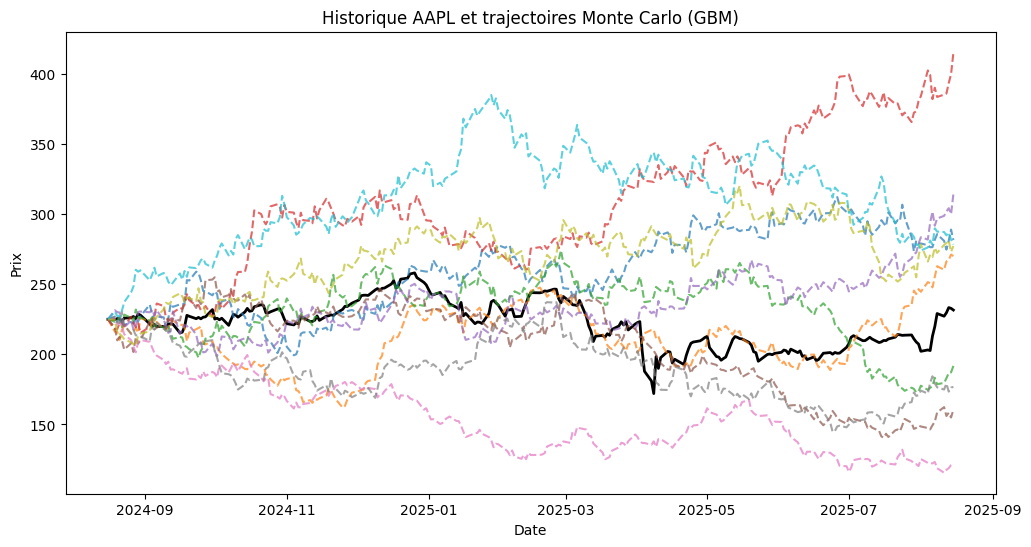

In [ ]:
# Exemple d'utilisation avec la classe Stock et GBMsimulator

# 1. Instancier l'objet Stock et télécharger les données
aapl = Stock("AAPL", "1y")
aapl.data_actif()

# 2. Estimer mu et sigma à partir des données historiques
mu, sigma = aapl.estimateur_mu_sigma()

# 3. Instancier le simulateur GBM avec les bons paramètres
S0 = aapl.data["Close"].iloc[0]
steps = len(aapl.data["Close"]) - 1  # pour coller à la longueur de l'historique
simu = GBMsimulator(S0=S0, mu=mu, sigma=sigma, T=1.0, steps=steps)

# 4. Simuler les trajectoires
n_paths = 10
paths = simu.simulate_gbm(n_paths)

# 5. Tracer l'historique et les trajectoires simulées
plt.figure(figsize=(12,6))
plt.plot(aapl.data.index, aapl.data["Close"], label="Historique", color="black", linewidth=2)
for i in range(n_paths):
    plt.plot(aapl.data.index, paths[i], alpha=0.7, linestyle="--")
plt.xlabel("Date")
plt.ylabel("Prix")
plt.title("Historique AAPL et trajectoires Monte Carlo (GBM)")

## Conclusion sur la comparaison historique / simulations Monte Carlo

Le graphique ci-dessus met en évidence l’évolution réelle du prix de l’actif (courbe noire épaisse) ainsi que plusieurs trajectoires simulées à l’aide de la méthode de Monte Carlo sous l’hypothèse d’un mouvement brownien géométrique (GBM).

On observe que :
- Les trajectoires simulées, bien que différentes, restent globalement cohérentes avec la dynamique historique de l’actif, car elles sont calibrées sur les paramètres statistiques $(\mu, \sigma)$ estimés à partir des données réelles.
- Plus l’horizon temporel s’allonge, plus les trajectoires simulées divergent : cela illustre l’incertitude croissante sur l’évolution future du prix, liée à la volatilité du marché.
- Ce type de simulation permet de visualiser la gamme des scénarios possibles et d’appréhender le risque associé à l’investissement sur cet actif.

**En résumé :**  
La superposition de l’historique et des trajectoires Monte Carlo offre une vision concrète de la variabilité potentielle du prix, et met en avant l’importance de la modélisation stochastique pour l’analyse